**Features selection**: From high dimensionnal data to small one

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Feature processing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBClassifier

# Metric and utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import zscore

# Warning
import warnings
warnings.filterwarnings("ignore")

* Utils

In [2]:
def kmer_count(sequence, k=3, step=1):
    kmers_count = {}
    s = 0
    for i in range(0, len(sequence) - k + 1, step):
        kmer = sequence[i:i + k]
        s += 1
        if kmer in kmers_count:
            kmers_count[kmer] += 1
        else:
            kmers_count[kmer] = 1
    for key, value in kmers_count.items():
        kmers_count[key] = value / s

    return kmers_count

* Set benchmark

In [3]:
dataset = pd.read_csv("../Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")

In [4]:
k = 6
sequences   = dataset['sequence']
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i], k=k, step=1))

In [5]:
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X = X_4 = pd.DataFrame(feature_values, columns=feature_names)
X_4.head()

,AAAAAA,AAAAAC,AAAAAG,AAAAAT,AAAACA,AAAACC,AAAACG,AAAACT,AAAAGA,AAAAGC,...,TTTTCG,TTTTCT,TTTTGA,TTTTGC,TTTTGG,TTTTGT,TTTTTA,TTTTTC,TTTTTG,TTTTTT
0,0.002182,0.000000,0.000436,0.000436,0.000436,0.000436,0.000000,0.000000,0.000436,0.000873,...,0.000436,0.001745,0.000873,0.000873,0.002182,0.001309,0.001309,0.000873,0.001745,0.001745
1,0.005450,0.000000,0.000681,0.002725,0.000681,0.000000,0.000000,0.000681,0.000681,0.000000,...,0.000000,0.004087,0.000000,0.001362,0.000681,0.001362,0.002044,0.001362,0.002044,0.004768
2,0.000339,0.000339,0.000339,0.001016,0.000677,0.000000,0.000339,0.000339,0.001355,0.000339,...,0.000339,0.002370,0.001693,0.000339,0.000339,0.002370,0.001355,0.001016,0.002032,0.002032
3,0.005000,0.001364,0.001818,0.000455,0.000455,0.000455,0.000000,0.000455,0.001818,0.000455,...,0.000455,0.002727,0.000000,0.000909,0.000455,0.000909,0.002727,0.001818,0.000455,0.004091
4,0.001004,0.001505,0.001505,0.000502,0.002007,0.000000,0.000502,0.000502,0.000000,0.001004,...,0.000000,0.002509,0.000502,0.000000,0.001505,0.002007,0.003512,0.001004,0.000502,0.006021


In [6]:
y = dataset['class']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

* Base line for model selection: <span style="color: blue;">Default Feature Importance: Random forests provide a built-in way to evaluate feature importance, which is helpful for feature selection tasks.</span>

In [7]:
# Tuned RF (pre-computed to save time)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [2, 4, 8, 16],
    'max_depth': [8, 16, 32, 64, 128]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_rf = grid_search.best_estimator_

In [8]:
best_params = grid_search.best_params_
best_params

{'max_depth': 16, 'max_features': 16, 'n_estimators': 300}

In [9]:
best_score = grid_search.best_score_
best_score

0.85

**Unsupervised feature selection**:

 * <span style="color: red">Variance-based(1)</span>

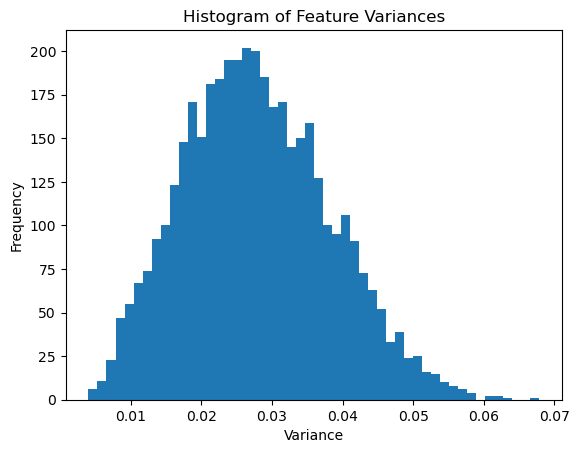

In [10]:
selector = VarianceThreshold().fit(MinMaxScaler().fit_transform(X))
variances = selector.variances_

plt.hist(variances, bins=50)
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Feature Variances')
plt.show()

Default Feature Importance: Random forests provide a built-in way to evaluate feature importance, which is helpful for feature selection tasks.

In [11]:
thresholds = np.linspace(0, variances.max(), 50)
param_grid = {'variance_threshold__threshold': thresholds}
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('variance_threshold', VarianceThreshold()),
    ('classifier', RandomForestClassifier())
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_threshold = grid_search.best_params_['variance_threshold__threshold']
print("Best threshold based on cross-validation:", best_threshold)

Best threshold based on cross-validation: 0.015236606437152439


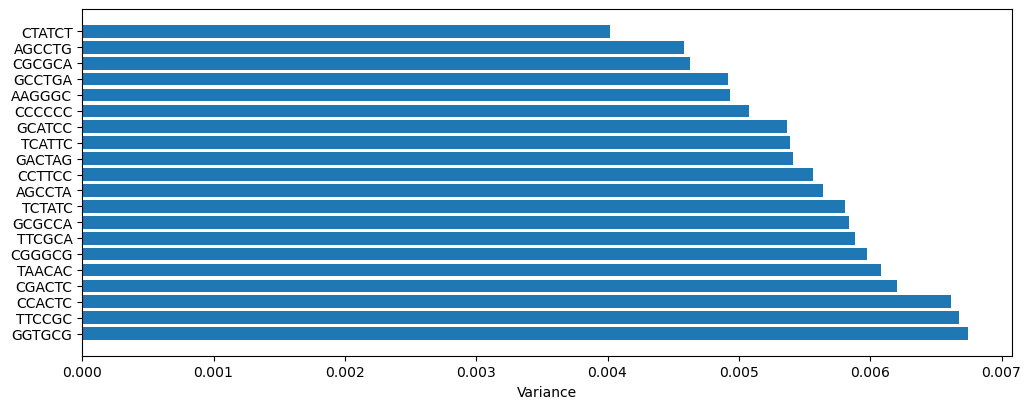

In [12]:
selector = VarianceThreshold(threshold=best_threshold).fit(MinMaxScaler().fit_transform(X))
variances = selector.variances_
var_sort = np.argsort(variances)

fig_scale = 3
feature_count = 20
plt.figure(figsize=(4*fig_scale, 1.5*fig_scale))
ypos = np.arange(feature_count)[::-1]
plt.barh(ypos, variances[var_sort][:feature_count], align='center')
plt.yticks(ypos, np.array(X.columns.values)[var_sort][:feature_count])
plt.xlabel("Variance");

In [13]:
selected_features = X.columns[selector.get_support()]
#print("Selected features based on initial quantile threshold:", selected_features.tolist())
print(f"Before selection= {len(X.columns.values)} / After = {len(selected_features)}")

Before selection= 4096 / After = 3644


In [14]:
best_score = grid_search.best_score_
print(best_score)

0.8657894736842104


**Note This method is not revelant:** since the base line model with all feature give "acc:0.8842" and the optimized one give "acc:0.894" with just one feature reduction

* <span style="color: red">Covariance based feature selection (2)</span>

In [15]:
#@features_names = X.columns.values
#X_scaled = scale(X)
#cov = np.cov(X_scaled, rowvar=False)

#order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")
#features_names_ordered = [features_names[i] for i in order]

#fig_scale=5
#plt.figure(figsize=(3*fig_scale, 3*fig_scale))
#plt.imshow(cov[order, :][:, order], cmap='bwr')
#plt.xticks(range(X.shape[1]), features_names_ordered, ha="right")
#plt.yticks(range(X.shape[1]), features_names_ordered)
#plt.xticks(rotation=45)
#plt.colorbar(fraction=0.046, pad=0.04);

**Note**: It will be very difficult to select features here. Also, we should check whenever one of two features correlates more with the target. While correlation-based feature selection can be useful, it may not always be the best method for k-mer representations of DNA sequences due to the following reasons: k-mer features, especially for higher values of k, can result in very high-dimensional feature spaces, making correlation-based methods less effective; the relationships between k-mers and the target may be more complex and not adequately captured by simple linear correlations.

* <span style="color: red">Supervised feature selection (3)</span>

    * Model-based
    * Univariate feature selection is a type of feature selection technique used in machine learning to select the most relevant features from the original feature set. It operates by evaluating the relationship between each feature and the target variable independently, without considering the relationship between features.

In [16]:
# Utils to plot feature importance 

def plot_feature_importances(method1='f_test', method2=None, threshold=0.5):
    # Plot scores
    features_names = X.columns.values
    x = np.arange(len(X.columns.values))
    fig_scale = 4
    fig, ax1 = plt.subplots(1, 1, figsize=(4*fig_scale, 1*fig_scale))
    w = 0.3
    imp = fs[method1]
    mask = imp['select'][threshold]
    m1 = ax1.bar(x[mask], imp['scaled_score'][mask], width=w, color='b', align='center')
    ax1.bar(x[~mask], imp['scaled_score'][~mask], width=w, color='b', align='center', alpha=0.3)
    if method2:
        imp2 = fs[method2]
        mask2 = imp2['select'][threshold]
        ax2 = ax1.twinx()
        m2 = ax2.bar(x[mask2] + w, imp2['scaled_score'][mask2], width=w,color='g',align='center')
        ax2.bar(x[~mask2] + w, imp2['scaled_score'][~mask2], width=w,color='g',align='center', alpha=0.3)
        plt.legend([m1, m2],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold]),
                             '{} (Ridge R2:{:.2f})'.format(imp2['label'],imp2['cv_score'][threshold])], loc='upper left')
    else:
        plt.legend([m1],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold])], loc='upper left')
    ax1.set_xticks(range(len(feature_names)))
    ax1.set_xticklabels(feature_names, rotation=45, ha="right");
    plt.title("Feature importance (selection threshold {:.2f})".format(threshold))        
    plt.show()

**Note**: We will use different techniques(supervised learning) to do feature selection then we use out utils "plot_feature_importances" to visualize and analyse.

In [17]:
from sklearn.feature_selection import f_classif, SelectPercentile, mutual_info_classif, SelectFromModel, RFE, SelectKBest, chi2
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from tqdm import tqdm

# Scaled feature selection thresholds
thresholds = [0.25, 0.5, 0.75, 1]

# Dict to store all data
fs = {}
methods = [
    'FTest','MutualInformation','RandomForest','Ridge','Lasso','RFE', 'ForwardSelection','FloatingForwardSelection', 'Permutation', 
    'knn'
]
for m in methods:
    fs[m] = {}
    fs[m]['select'] = {}
    fs[m]['cv_score'] = {}

def cv_score(selector):
    model = RandomForestClassifier()
    select_pipe = make_pipeline(StandardScaler(), selector, model)    
    return np.mean(cross_val_score(select_pipe, X, y, cv=5))

# We already tuned RF (pre-computed to save time)
randomforestCV = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)

In [18]:
# We define a 'template' model with full features and another one that will use selected features to see if feature selection 
# improves the model.

def assess_model_on_full_features(model):
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    print("[ALL_FEATURE] -- Cross-validated accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_scores), np.std(cv_scores)))

def assess_model_on_selected_features(mask, model):
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    mask_series = pd.Series(mask, index=X.columns)
    index_where_true = mask_series.index[mask_series.values]
    X_reduced = X[index_where_true] 
    cv_scores = cross_val_score(model, X_reduced, y, cv=kfold, scoring='accuracy')
    print("[SELECTED_FEATURE] -- Cross-validated accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_scores), np.std(cv_scores)))

* F-TEST
    * Consider each feature individually (univariate), independent of the model that you aim to apply
    * Use a statistical test: is there a linear statistically significant relationship with the target?
    * Use F-statistic (or corresponding p value) to rank all features, then select features using a threshold
    * Cannot detect correlations or interactions (e.g. binary features)
    * <span style="color: red;">F-TEST</span>

In [19]:
# F test
print("Computing F test")
fs['FTest']['label'] = "F test"
fs['FTest']['score'] = f_classif(scale(X),y)[0]
fs['FTest']['scaled_score'] = fs['FTest']['score'] / np.max(fs['FTest']['score'])
for t in tqdm(thresholds):
    selector = SelectPercentile(score_func=f_classif, percentile=t*100).fit(scale(X), y)
    fs['FTest']['select'][t] = selector.get_support()
    fs['FTest']['cv_score'][t] = cv_score(selector)

Computing F test


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


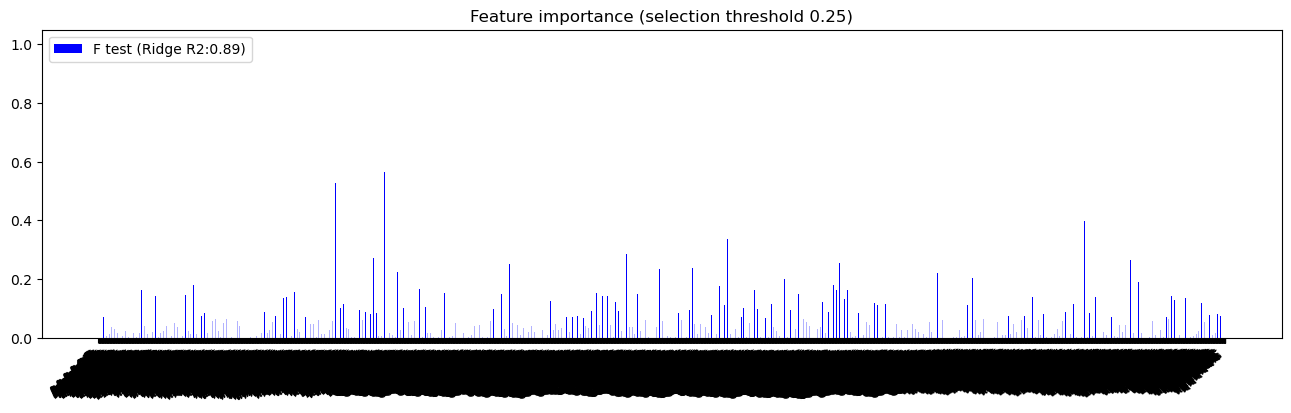

In [20]:
threshold=0.25
plot_feature_importances('FTest', None, threshold=threshold)

In [21]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['FTest']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.8132 ± 0.0529
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.8842 ± 0.0347


**Note**: For any value of threshold it does not improve prediction

* Model based feature selection
    * Use a tuned(!) supervised model to judge the importance of each feature
    * Linear models (Ridge, Lasso, LinearSVM,…): features with highest weights (coefficients)
    * Tree–based models: features used in first nodes (high information gain)
    * Captures interactions: features are more/less informative in combination
    * RandomForests: learns complex interactions (e.g. hour), but biased to high cardinality features
    * <span style="color: red">Random Forest</span>

In [22]:
# Random Forest
print("Computing Random Forest")
rf = randomforestCV
fs['RandomForest']['label'] = "Random Forest"
fs['RandomForest']['score'] = rf.fit(X, y).feature_importances_
fs['RandomForest']['scaled_score'] = fs['RandomForest']['score'] / np.max(fs['RandomForest']['score'])

for t in tqdm(thresholds):
    selector = SelectFromModel(rf, threshold="{}*mean".format((1-t)*2)).fit(X, y)
    fs['RandomForest']['select'][t] = selector.get_support()
    fs['RandomForest']['cv_score'][t] = cv_score(selector)

Computing Random Forest


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.58s/it]


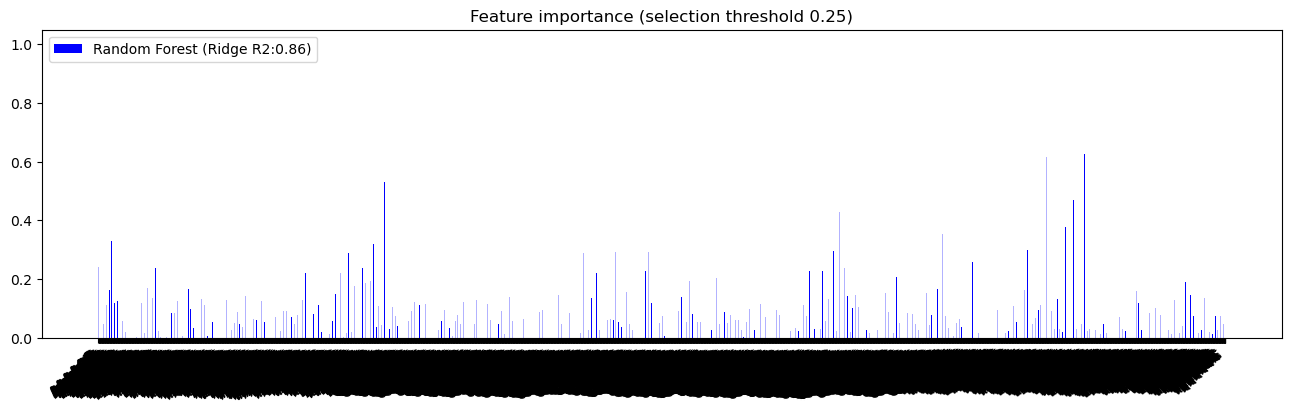

In [23]:
threshold=0.25
plot_feature_importances('RandomForest', None, threshold=threshold)

In [24]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['RandomForest']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.8158 ± 0.0416
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.8605 ± 0.0244


* Model based feature selection
    * Use a tuned(!) supervised model to judge the importance of each feature
    * Linear models (Ridge, Lasso, LinearSVM,…): features with highest weights (coefficients)
    * Tree–based models: features used in first nodes (high information gain)
    * Captures interactions: features are more/less informative in combination
    * RandomForests: learns complex interactions (e.g. hour), but biased to high cardinality features
    * <span style="color: red">Ridge, Lasso</span>

In [25]:
# Ridge, Lasso
for m in [RidgeCV(),LassoCV()]:
    name = m.__class__.__name__.replace('CV','')
    print("Computing", name)
    fs[name]['label'] = name
    fs[name]['score'] = m.fit(X, y).coef_
    fs[name]['scaled_score'] = np.abs(fs[name]['score']) / np.max(np.abs(fs[name]['score'])) # Use absolute values
    for t in tqdm(thresholds):
        selector = SelectFromModel(m, threshold="{}*mean".format((1-t)*2)).fit(scale(X), y)
        fs[name]['select'][t] = selector.get_support()
        fs[name]['cv_score'][t] = cv_score(selector)

Computing Ridge


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]


Computing Lasso


100%|█████████████████████████████████████████████████████████████████████████| 4/4 [06:43<00:00, 100.91s/it]


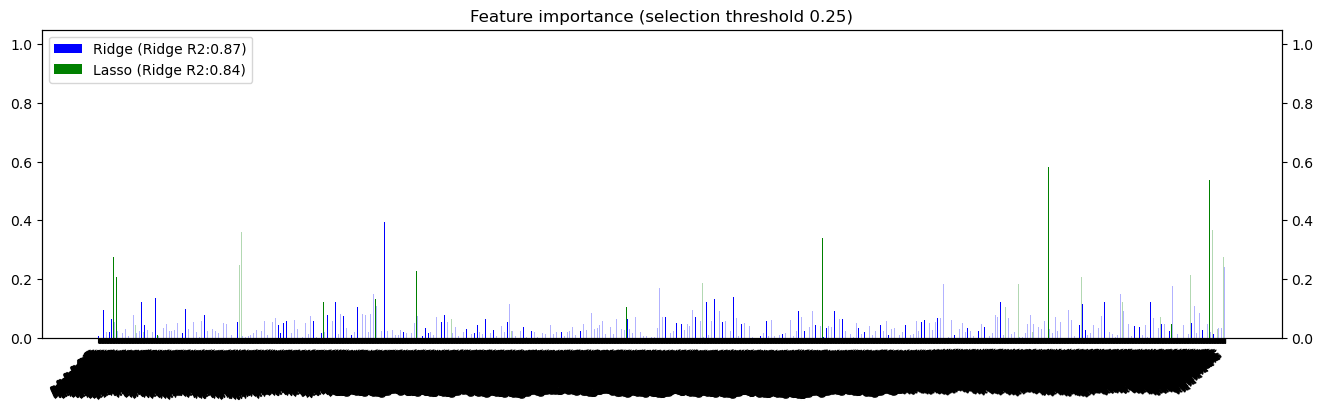

In [26]:
threshold=0.25
plot_feature_importances('Ridge', 'Lasso', threshold=threshold)

In [27]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['Lasso']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7947 ± 0.0339
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.9474 ± 0.0288


In [28]:
# Mutual information
print("Computing Mutual information")
fs['MutualInformation']['label'] = "Mutual Information"
fs['MutualInformation']['score'] = mutual_info_classif(scale(X),y,discrete_features=range(13)) # first 13 features are discrete
fs['MutualInformation']['scaled_score'] = fs['MutualInformation']['score'] / np.max(fs['MutualInformation']['score'])
for t in tqdm(thresholds):
    selector = SelectPercentile(score_func=mutual_info_classif, percentile=t*100).fit(scale(X), y)
    fs['MutualInformation']['select'][t] = selector.get_support()
    fs['MutualInformation']['cv_score'][t] = cv_score(selector)

Computing Mutual information


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [01:22<00:00, 20.73s/it]


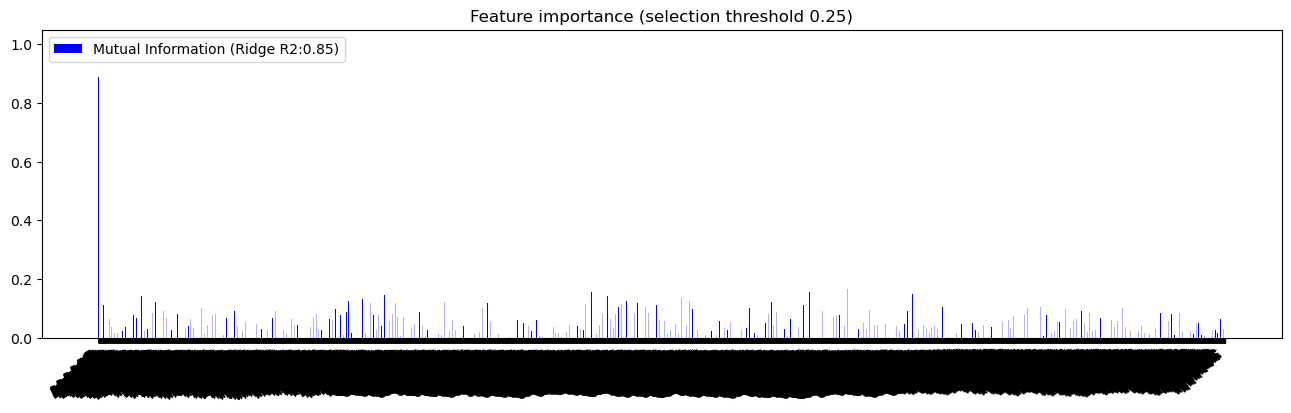

In [29]:
threshold=0.25
plot_feature_importances('MutualInformation', None, threshold=threshold)

In [30]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(fs['MutualInformation']['select'][threshold], model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.8105 ± 0.0568
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.8632 ± 0.0387


* <span style="color: red">New Feature selection for k-mer (Motif Independent Measure (MIM))</span>
    * https://www.researchgate.net/publication/268977663_A_new_feature_selection_strategy_for_K-mers_sequence_representation
    * **Paper**: The idea behind the proposed feature selection method is to assign a weight to each k-mer, and use this weights for their selection.

In [31]:
# let P be the k-mer probability distributions corresponding to a set of n target sequences S = {si}
P = X.to_numpy()
# Let Q be the k-mer probability distributions corresponding to B for a fixed length k.
Q = None

Symmetrical Kullback-Leibler divergence between the empirical probabilities Pj and Qj

In [32]:
def kullback_leibler_divergence(P, Q):
    J = P.shape[1]
    dkl = np.zeros(J)
    epsilon = 1e-10
    for j in range(J):
        P_j = P[:, j]
        Q_j = Q[:, j]
        P_j = np.where(P_j == 0, epsilon, P_j)
        Q_j = np.where(Q_j == 0, epsilon, Q_j)
        dkl[j] = 0.5 * (np.sum(P_j * np.log(P_j / Q_j)) + np.sum(Q_j * np.log(Q_j / P_j)))
    return dkl

The Motif Independent Measure (MIM) value corresponding to ak-mer wj is defined as the expected value dkl(Pj , Qj ), which is estimated by averagingover a finite set N > n of background sequences, and is indicated as MIM(wj ). 

In [33]:
def MIM_Feature_Selector(P, Q, alpha, beta):
    assert alpha < 1 and beta < 1, "Error: alpha and beta should be lower than 1"
    m = P.shape[1]
    mim_values = kullback_leibler_divergence(P, Q)
    z_scores = zscore(mim_values)
    
    # Identify k-mers with Z-scores above the threshold
    A_alpha_pos = np.where(np.abs(z_scores) > alpha)[0]
    A_alpha = mim_values[A_alpha_pos]
    
    # Select the number of k-mers based on the criteria
    r = max(np.linalg.norm(A_alpha, ord=1), int(beta * m))
    selected_kmers_indices = np.argsort(mim_values)[:r]

    # Generate mask
    selection_mask = np.zeros(m, dtype=bool)
    selection_mask[selected_kmers_indices] = True
    
    return selection_mask

* Test

In [34]:
# USING FULL FEATURE AS BACKGROUND SEQUENCE

alpha = 0.7
beta = 0.5
feature_mask_1 = MIM_Feature_Selector(P, P, alpha, beta)
print(f"Feature before: {len(X.columns.values)} - Feature After: {np.sum(feature_mask_1)}")

Feature before: 4096 - Feature After: 2048


In [35]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16) 
assess_model_on_full_features(model) 
assess_model_on_selected_features(feature_mask_1, model) 

[ALL_FEATURE] -- Cross-validated accuracy: 0.8158 ± 0.0250
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.8158 ± 0.0235


In [36]:
# USING NEGATIVE BACKGROUND AS BACKGROUND SEQUENCE
kmers_count = []
for i in range(len(sequences)):
    kmers_count.append(kmer_count(sequences[i][::-1], k=k, step=1))
    
v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_inv = pd.DataFrame(feature_values, columns=feature_names)
Q = X_inv.to_numpy()

alpha = 0.7
beta = 0.5
feature_mask_2 = MIM_Feature_Selector(P, Q, alpha, beta)
print(f"Feature before: {len(X.columns.values)} - Feature After: {np.sum(feature_mask_2)}")

Feature before: 4096 - Feature After: 2048


In [37]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(feature_mask_2, model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7895 ± 0.0448
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.8132 ± 0.0305


In [38]:
# USING RANDOM BACKGROUND SELECTION

from itertools import product
def calculate_nucleotide_probabilities(sequences, k):
    kmers_count = []
    for seq in sequences:
        nucleotide_counts = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
        total_nucleotides = 0
        kmers = {}
        
        for nucleotide in seq:
            if nucleotide in nucleotide_counts:
                nucleotide_counts[nucleotide] += 1
                total_nucleotides += 1
    
        probabilities = {nucleotide: count / total_nucleotides for nucleotide, count in nucleotide_counts.items()}
        nucleotides = list(probabilities.keys())
    
        for kmer in product(nucleotides, repeat=k):
            kmer_prob = np.prod([probabilities[n] for n in kmer])
            kmers[''.join(kmer)] = kmer_prob
        
        kmers_count.append(kmers)
    return kmers_count
        
kmers_count = calculate_nucleotide_probabilities(sequences, k)

v = DictVectorizer(sparse=False)
feature_values = v.fit_transform(kmers_count)
feature_names = v.get_feature_names_out()
X_inv = pd.DataFrame(feature_values, columns=feature_names)
Q = X_inv.to_numpy()

alpha = 0.7
beta = 0.5
feature_mask_3 = MIM_Feature_Selector(P, Q, alpha, beta)
print(f"Feature before: {len(X.columns.values)} - Feature After: {np.sum(feature_mask_2)}")

Feature before: 4096 - Feature After: 2048


In [39]:
model = RandomForestClassifier(n_estimators=100, max_features=8, max_depth=16)
assess_model_on_full_features(model)
assess_model_on_selected_features(feature_mask_3, model)

[ALL_FEATURE] -- Cross-validated accuracy: 0.7842 ± 0.0318
[SELECTED_FEATURE] -- Cross-validated accuracy: 0.8053 ± 0.0226


<h4 style="background-color: #3ab76f; border-top: 4px solid #dddddd; display: flex; color: white;">
    <ul><li>RESULT</li></ul>
</h4>

* Utils

In [40]:
def prepare_dataset(k):
    sequences   = dataset['sequence']
    kmers_count = []
    for i in range(len(sequences)):
        kmers_count.append(kmer_count(sequences[i], k=k, step=1))
    v = DictVectorizer(sparse=False)
    feature_values = v.fit_transform(kmers_count)
    feature_names = v.get_feature_names_out()
    X = pd.DataFrame(feature_values, columns=feature_names)
    y = dataset['class']
    return X,y

def tune_model(model_conf, X, y):
    best_models = []
    for config in model_conf:
        name = config['name']
        model = config['model']
        params = config['params']
        
        print(f"Tuning {name}")
        if params:
            grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            print(f"Best params for {name}: {best_params}")
        else:
            best_model = model
            print(f"No hyperparameters to tune for {name}")
    
        best_models.append({
            'name': name,
            'model': best_model,
        })
    return best_models
    
def trace_model_performance(traced_performance, tuned_models, feature_mask, feature_selection_method, X, y, k_mer_size, out=""):
    for model_info in tuned_models:
        name = model_info['name']
        model = model_info['model']
        
        # Apply the feature mask if provided
        feature_name = "-".join(X.columns.values)
        if feature_mask is not None:
            mask_series = pd.Series(feature_mask, index=X.columns)
            selected_features = mask_series[mask_series].index
            X_reducted = X[selected_features]
            feature_name = "-".join(selected_features)
        else:
            X_reducted = X

        print(f"Evaluating {name} with feature selection method: {feature_selection_method}")
        X_train, X_test, y_train, y_test = train_test_split(X_reducted, y, train_size=0.8, stratify=y)

        # Perform cross-validation
        kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])
        best_score = np.mean(cv_results['test_accuracy'])
        std_score = np.std(cv_results['test_accuracy'])
        precision = np.mean(cv_results['test_precision'])
        recall = np.mean(cv_results['test_recall'])
        f1 = np.mean(cv_results['test_f1'])

        # Fit the best model
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        traced_performance.append({
            'name': name,
            'model': model,
            'test_score': accuracy_score(y_test, predictions),
            'train_score': best_score,
            'train_std_score': std_score,
            'train_precision': precision,
            'train_recall': recall,
            'train_f1': f1,
            'feature_selection_method': feature_selection_method,
            'k-mer size': k_mer_size,
            'feature_mask': feature_name
        })

        # SAVE RESULT
        df_performance = pd.DataFrame(traced_performance)
        df_performance.to_csv(out, index=False)

* Model

In [41]:
model_conf = [
    {'name':'GaussianProcessClassifier', 'model':GaussianProcessClassifier(), "params": {'kernel': [1.0 * RBF(1.0), 1.0 * RBF(0.5), 1.0 * RBF(2.0)]}},
    {'name':'RandomForestClassifier', 'model':RandomForestClassifier(), "params": {'max_depth': [8, 16, 32, 64, 128], 'n_estimators': [10, 50, 100, 200, 300], 'max_features': [2, 4, 8, 16]}},
    {'name':'AdaBoostClassifier', 'model':AdaBoostClassifier(algorithm="SAMME"), "params": {'n_estimators': [50, 100, 200]}},
    {'name':'GaussianNB', 'model':GaussianNB(), "params": None},
]

In [42]:
X, y = prepare_dataset(k)
traced_performance = []
threshold = 0.25
path_result=f'../Output/FSelect/result_k_{k}.csv'

In [43]:
tuned_models = tune_model(model_conf, X, y)

Tuning GaussianProcessClassifier
Best params for GaussianProcessClassifier: {'kernel': 1**2 * RBF(length_scale=0.5)}
Tuning RandomForestClassifier
Best params for RandomForestClassifier: {'max_depth': 16, 'max_features': 16, 'n_estimators': 300}
Tuning AdaBoostClassifier
Best params for AdaBoostClassifier: {'n_estimators': 200}
Tuning GaussianNB
No hyperparameters to tune for GaussianNB


In [44]:
tuned_models

[{'name': 'GaussianProcessClassifier',
  'model': GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=0.5))},
 {'name': 'RandomForestClassifier',
  'model': RandomForestClassifier(max_depth=16, max_features=16, n_estimators=300)},
 {'name': 'AdaBoostClassifier',
  'model': AdaBoostClassifier(algorithm='SAMME', n_estimators=200)},
 {'name': 'GaussianNB', 'model': GaussianNB()}]

In [45]:
trace_model_performance(traced_performance, tuned_models, None, "No", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: No
Evaluating RandomForestClassifier with feature selection method: No
Evaluating AdaBoostClassifier with feature selection method: No
Evaluating GaussianNB with feature selection method: No


In [46]:
trace_model_performance(traced_performance, tuned_models, None, "Variance-based(1)", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: Variance-based(1)
Evaluating RandomForestClassifier with feature selection method: Variance-based(1)
Evaluating AdaBoostClassifier with feature selection method: Variance-based(1)
Evaluating GaussianNB with feature selection method: Variance-based(1)


In [47]:
trace_model_performance(traced_performance, tuned_models, fs['FTest']['select'][threshold], "FTest", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: FTest
Evaluating RandomForestClassifier with feature selection method: FTest
Evaluating AdaBoostClassifier with feature selection method: FTest
Evaluating GaussianNB with feature selection method: FTest


In [48]:
trace_model_performance(traced_performance, tuned_models, fs['RandomForest']['select'][threshold], "RandomForest", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: RandomForest
Evaluating RandomForestClassifier with feature selection method: RandomForest
Evaluating AdaBoostClassifier with feature selection method: RandomForest
Evaluating GaussianNB with feature selection method: RandomForest


In [49]:
trace_model_performance(traced_performance, tuned_models, fs['Lasso']['select'][threshold], "Lasso", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: Lasso
Evaluating RandomForestClassifier with feature selection method: Lasso
Evaluating AdaBoostClassifier with feature selection method: Lasso
Evaluating GaussianNB with feature selection method: Lasso


In [50]:
trace_model_performance(traced_performance, tuned_models, fs['MutualInformation']['select'][threshold], "MutualInformation", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: MutualInformation
Evaluating RandomForestClassifier with feature selection method: MutualInformation
Evaluating AdaBoostClassifier with feature selection method: MutualInformation
Evaluating GaussianNB with feature selection method: MutualInformation


In [51]:
trace_model_performance(traced_performance, tuned_models, feature_mask_1, "MIM-FULL", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: MIM-FULL
Evaluating RandomForestClassifier with feature selection method: MIM-FULL
Evaluating AdaBoostClassifier with feature selection method: MIM-FULL
Evaluating GaussianNB with feature selection method: MIM-FULL


In [52]:
trace_model_performance(traced_performance, tuned_models, feature_mask_2, "MIM-NB", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: MIM-NB
Evaluating RandomForestClassifier with feature selection method: MIM-NB
Evaluating AdaBoostClassifier with feature selection method: MIM-NB
Evaluating GaussianNB with feature selection method: MIM-NB


In [53]:
trace_model_performance(traced_performance, tuned_models, feature_mask_3, "MIM-RB", X, y, k, out=path_result)

Evaluating GaussianProcessClassifier with feature selection method: MIM-RB
Evaluating RandomForestClassifier with feature selection method: MIM-RB
Evaluating AdaBoostClassifier with feature selection method: MIM-RB
Evaluating GaussianNB with feature selection method: MIM-RB


In [54]:
# VIEW RESULT
df_performance = pd.read_csv(path_result)
#df_performance